### Time to get your hands dirty! Fun with Gamma Ray Bursts.
Let's look at the latest database of Gamma Ray Bursts.

The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html
This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research here!). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. Be creative! You're discovering

Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed?

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, LeaveOneOut
import corner
from astroML.density_estimation import EmpiricalDistribution
from sklearn.mixture import GaussianMixture
from astroML import stats as astroMLstats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import confusion_matrix

url = 'https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt'
r = requests.get(url, allow_redirects=True)
open('grb_dataset.npy', 'wb').write(r.content)

#read the dataset
data = np.loadtxt('grb_dataset.txt', dtype = str, comments='#', unpack = True)
# Read headers
with open("grb_dataset.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])


In [2]:
#since after deleting every line presenting absent data (-999) we are left with few samples -> clone the empirical distributions
#try both kde fit and gaussian mixture fit

T90 = np.array(data[6].astype(np.float), dtype=float)
T90 = np.sort(T90)
T90 = np.delete(T90, np.where(T90 <= 0))


t_plot = np.logspace(-2.5, 3.5, 1000)[:, np.newaxis]

#set bin size using Freedman Diaconis rule
sigmaG = astroMLstats.sigmaG(np.log10(T90))
binsize = 2.7*sigmaG/(len(T90)**(1/3))
binsFD = np.append(np.arange(start=np.log10(T90.min()), stop=np.log10(T90.max()), step=binsize) , np.log10(T90.max()))
bwFD = binsFD[2]-binsFD[1]

#kde fit
kde = KernelDensity(kernel = "gaussian", bandwidth = bwFD).fit(np.log10(T90).reshape(-1,1))
log_dens = kde.score_samples(np.log10(t_plot))

#gaussian mixture
ncomp = 2
gm = GaussianMixture(n_components = ncomp, n_init = 20).fit(np.log10(T90)[:, np.newaxis])
pdf = np.exp(gm.score_samples(np.log10(t_plot)))
resp = gm.predict_proba(np.log10(T90)[:, np.newaxis])


gmm = gm.means_ 

if gmm[0]>gmm[1]:
    gmm = gmm[::-1]
    resp = resp[:, ::-1]
    
print(gmm)
   
gm_result = np.array(resp[:,0]<resp[:,1], dtype = 'int')



/tmp/ipykernel_23831/2187505866.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T90 = np.array(data[6].astype(np.float), dtype=float)


[[-0.01556197]
 [ 1.4931735 ]]


In [3]:
#clustering algorithm kmeans
clf = KMeans(n_clusters=2) 
clf.fit((np.log10(T90).reshape(-1,1)))
#find clusters centers
centers_k = clf.cluster_centers_
#labels for each of the points
labels_k = clf.predict(np.log10(T90).reshape(-1,1))
threshold_k = np.mean(centers_k)

if centers_k[0]>centers_k[1]:
    centers_k=centers_k[::-1] # Reverse array
    labels_k = np.array(~np.array(labels_k,dtype='bool'),dtype='int')


In [4]:
# MeanShift
sc = StandardScaler()
bw = 0.5

meanshift = MeanShift(bandwidth = bw, bin_seeding = True, cluster_all = False, n_jobs = -1)
meanshift.fit(sc.fit_transform(np.log10(T90).reshape(-1,1)))

#find clusters centers
centers_ms = sc.inverse_transform(meanshift.cluster_centers_)
#labels for each of the points
labels_ms = meanshift.predict(np.log10(T90).reshape(-1,1))
threshold_ms = np.mean(centers_ms)

if centers_ms[0]>centers_ms[1]:
    centers_ms=centers_ms[::-1] # Reverse array
    labels_ms = np.array(~np.array(labels_ms,dtype='bool'),dtype='int')


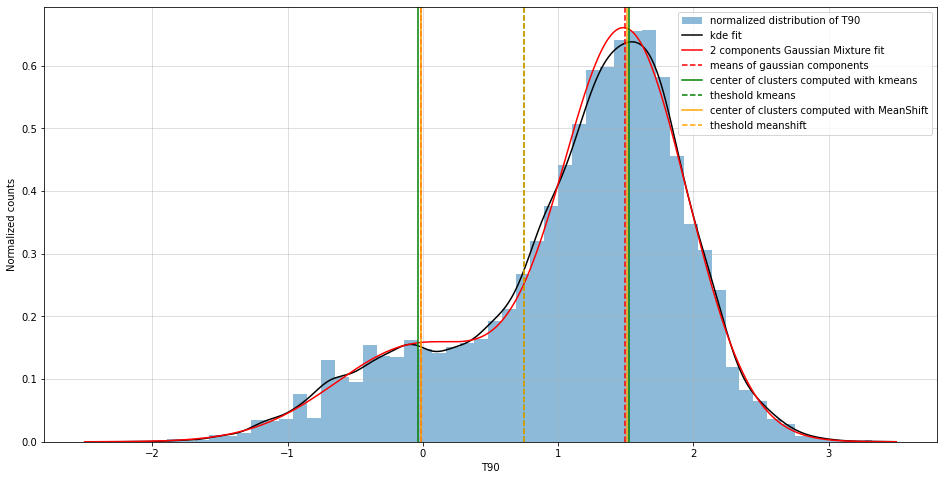

In [5]:
fig = plt.figure(figsize=(16, 8))
#plt.hist(np.log10(T90), bins = 50, density = True, alpha = 0.5, label = 'normalized distribution of T90')
plt.hist(np.log10(T90), bins = binsFD, density = True, alpha = 0.5, label = 'normalized distribution of T90')
plt.plot(np.log10(t_plot[:, 0]), np.exp(log_dens), color = "black", label = 'kde fit')
plt.plot(np.log10(t_plot[:, 0]), pdf, color = "red", label = '2 components Gaussian Mixture fit')
plt.axvline(gm.means_[:,0][0], color = 'red', ls = '--', label = 'means of gaussian components')
plt.axvline(gm.means_[:,0][1], color = 'red', ls = '--')

plt.axvline(centers_k[1,0], color = "green", label = "center of clusters computed with kmeans")
plt.axvline(centers_k[0,0], color = "green")
plt.axvline(threshold_k, color = "green", linestyle = "dashed", label = 'theshold kmeans')

plt.axvline(centers_ms[1,0], color = "orange", label = "center of clusters computed with MeanShift")
plt.axvline(centers_ms[0,0], color = "orange")
plt.axvline(threshold_ms, color = "orange", linestyle = "dashed", label = 'theshold meanshift')

plt.xlabel('T90')
plt.ylabel('Normalized counts')

plt.grid(alpha = 0.5)
plt.legend()
plt.show()

In [6]:
### print centers
print('center_1 MeanShift = ' + str(centers_ms[0]))
print('center_2 MeanShift = ' + str(centers_ms[1]))

print('center_1 KMeans = ' + str(centers_k[0]))
print('center_2 KMeans = ' + str(centers_k[1]))

print('center_1 Gaussian Mixture = ' + str(gmm[0]))
print('center_2 Gaussian Mixture = ' + str(gmm[1]))


center_1 MeanShift = [-0.01539272]
center_2 MeanShift = [1.50618251]
center_1 KMeans = [-0.038981]
center_2 KMeans = [1.527639]
center_1 Gaussian Mixture = [-0.01556197]
center_2 Gaussian Mixture = [1.4931735]


In [7]:
#print confusion matrix for kmeans
cm_gm_k= confusion_matrix(labels_k, gm_result)

print("Gaussian Mixture vs Kmeans confusion matrix")
print(cm_gm_k)


Gaussian Mixture vs Kmeans confusion matrix
[[1543  251]
 [   0 5188]]


The T90 distribution shows a bimodality due to the fact that GRBs can be either long (I component with log-mean = 1.49) or short (II component with log-mean = -0.016)

/tmp/ipykernel_23831/1858751360.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.array(data[11].astype(np.float),dtype=float)


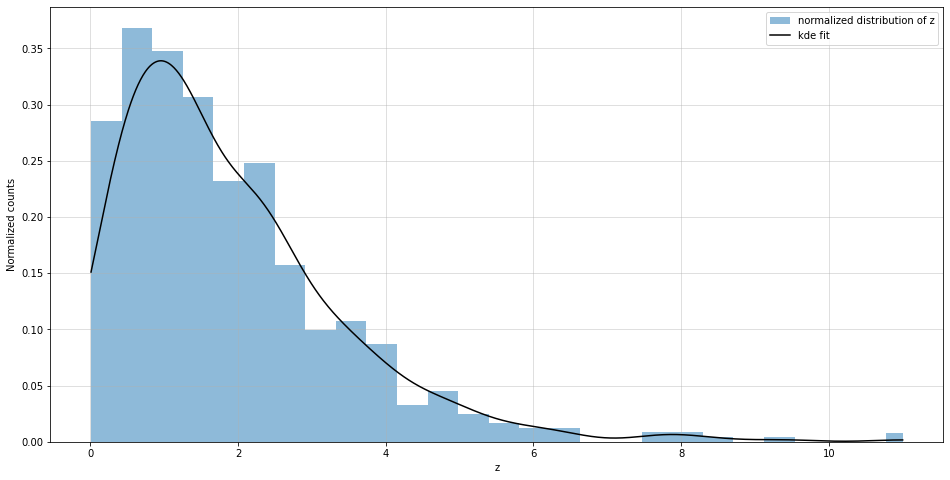

In [8]:
z = np.array(data[11].astype(np.float),dtype=float)
z = np.delete(z, np.where(z < 0))
z_plot = np.linspace(z.min(), z.max(), 1000)

#set bin size using Freedman Diaconis rule
sigmaG = astroMLstats.sigmaG(z)
binsize = 2.7*sigmaG/(len(z)**(1/3))
binsFD = np.append(np.arange(start=z.min(), stop=z.max(), step=binsize), z.max())
bwFD = binsFD[2]-binsFD[1]

#kde fit
kde = KernelDensity(kernel = "gaussian", bandwidth = bwFD).fit(z.reshape(-1,1))
log_dens = kde.score_samples(z_plot.reshape(-1, 1))

fig = plt.figure(figsize=(16, 8))
plt.hist(z, bins = binsFD, density = True, alpha = 0.5, label = 'normalized distribution of z')
plt.plot(z_plot, np.exp(log_dens), color = "black", label = 'kde fit')
plt.legend()
plt.grid(alpha = 0.5)

plt.xlabel('z')
plt.ylabel('Normalized counts')
plt.show()

/tmp/ipykernel_23831/3600331011.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fluence = np.array(data[9].astype(np.float),dtype=float)


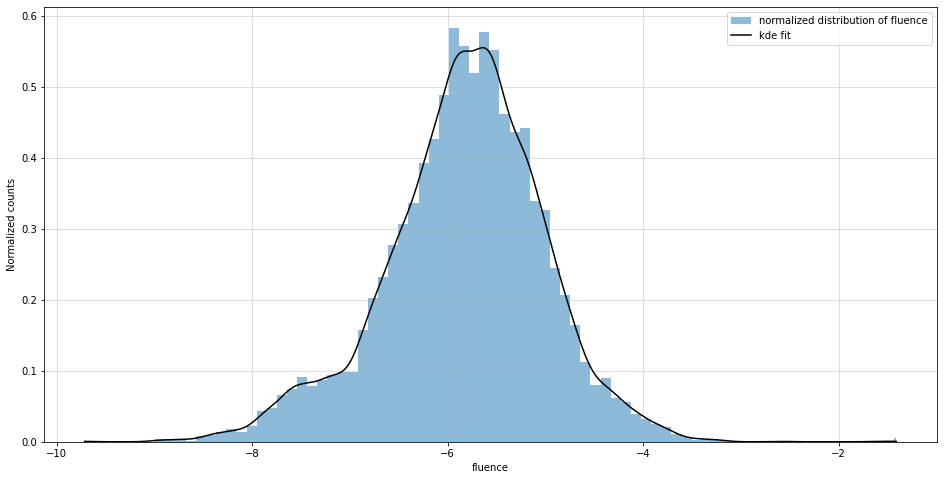

In [9]:
fluence = np.array(data[9].astype(np.float),dtype=float)
fluence = np.delete(fluence, np.argwhere(fluence <= 0))
f_plot = np.logspace(np.log10(fluence).min(), np.log10(fluence).max(), 1000)[:, np.newaxis]

#set bin size using Freedman Diaconis rule
sigmaG = astroMLstats.sigmaG(np.log10(fluence))
binsize = 2.7*sigmaG/(len(fluence)**(1/3))
binsFD = np.append(np.arange(start=np.log10(fluence.min()), stop=np.log10(fluence.max()), step=binsize) , np.log10(fluence.max()))
bwFD = binsFD[2]-binsFD[1]

#kde fit
kde = KernelDensity(kernel = "gaussian", bandwidth = bwFD).fit(np.log10(fluence).reshape(-1,1))
log_dens = kde.score_samples(np.log10(f_plot))

fig = plt.figure(figsize=(16, 8))
plt.hist(np.log10(fluence), bins = binsFD, density = True, alpha = 0.5, label = 'normalized distribution of fluence')
plt.plot(np.log10(f_plot[:, 0]), np.exp(log_dens), color = "black", label = 'kde fit')

plt.legend()
plt.grid(alpha = 0.5)
plt.xlabel('fluence')
plt.ylabel('Normalized counts')

plt.show()

In [10]:
# 2 expected clusters divided on the burst duration, sGRB and lGRB
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
from sklearn import preprocessing

data_cut = data[[6, 9, 11]].astype(np.float)
data_cut = np.delete(data_cut, np.where(data_cut <= 0), axis=1 )    

data_cluster = np.log10(data_cut[[0,1]].T)
print(data_cluster.shape)


(545, 2)


/tmp/ipykernel_23831/2292372603.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_cut = data[[6, 9, 11]].astype(np.float)


[[ 0.65084819 -6.40457266]
 [ 1.84254762 -5.1742834 ]]


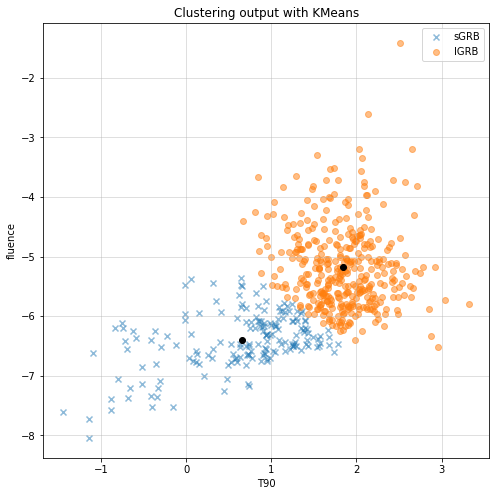

In [19]:
#plotting clusters with centers in T90/fluence axes using kmeans

#find centers with kmeans
clf = KMeans(n_clusters=2) 
clf.fit(data_cluster)
#find clusters centers
centers_k = clf.cluster_centers_
print(centers_k)

#labels for each of the points
labels_pred = clf.predict(data_cluster) 

fig = plt.figure(figsize=(8, 8))

# plot the data with different markers depending on size
markers = ["x", "o"]

labs = ['sGRB', 'lGRB']
for ii in range(2):
    plt.scatter(data_cluster[labels_pred==ii,0], data_cluster[labels_pred==ii,1], marker = markers[ii], label = labs[ii], alpha=0.5, cmap=plt.cm.get_cmap('jet'))

# To get some information on these try:

plt.title('Clustering output with KMeans')
plt.xlabel('T90')
plt.ylabel('fluence')
plt.scatter (centers_k[:, 0], centers_k[:, 1], color = "black")
plt.grid(alpha = 0.5)
plt.legend()
plt.show()

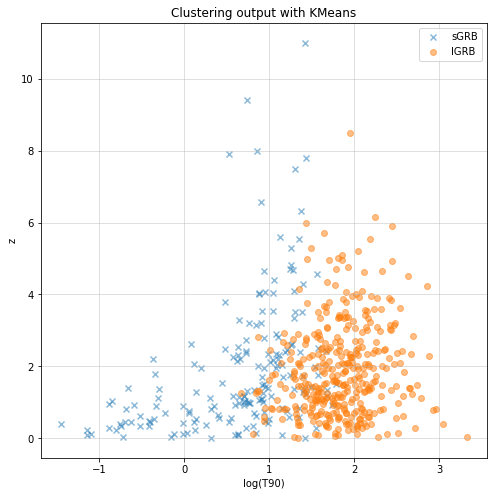

In [39]:
# plot the data with different markers depending on size
markers = ["x", "o"]
labs = ['sGRB', 'lGRB']
fig = plt.figure(figsize=(8, 8))
for ii in range(2):
    plt.scatter(data_cluster[labels_pred==ii,0], data_cut[2,labels_pred==ii], marker = markers[ii], label = labs[ii], alpha=0.5, cmap=plt.cm.get_cmap('jet'))


plt.title('Clustering output with KMeans')
plt.xlabel('log(T90)')
plt.ylabel('z')
plt.grid(alpha = 0.5)
plt.legend()
plt.show()

sGRB are closer (lower z), while lgRB are at higher z. This is due to the nature of the event:
-sGRB are produced by kilonovae (merger of binary NS or NS-BH binary)
-lGRB are produced by supernovae